In [1]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.applications.vgg16 import VGG16
from keras import models
from keras.layers import Flatten, Dense, Input
from keras.applications.resnet50 import ResNet50
from keras import optimizers
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Convolution2D, GlobalAveragePooling2D
from  keras.callbacks import ModelCheckpoint
from keras.regularizers import l2

Using TensorFlow backend.


In [2]:
IS = 224

BATCH_SIZE = 128

train_dir = 'val'
validation_dir = 'test'

EPOCHS = 35

In [3]:
datagen_train = ImageDataGenerator(rotation_range=30.,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
datagen_val = ImageDataGenerator()

batch_size = BATCH_SIZE 
 
# train_features = np.zeros(shape=(nTrain, 224, 224, 3))# 3,3,512
# train_labels = np.zeros(shape=(nTrain,3))
 
train_generator = datagen_train.flow_from_directory(
    train_dir,
    target_size=(IS, IS),
    batch_size=batch_size,
    interpolation = "nearest",
    class_mode='categorical',
    shuffle=True
    )


# validation_features = np.zeros(shape=(nVal, 224, 224, 3))
# validation_labels = np.zeros(shape=(nVal,3))
 
validation_generator = datagen_val.flow_from_directory(
    validation_dir,
    target_size=(IS, IS),
    batch_size=batch_size,
    interpolation = "nearest",
    class_mode='categorical',
    shuffle=True)

Found 29970 images belonging to 5 classes.
Found 9990 images belonging to 5 classes.


In [4]:
# not including the top layer
model_vgg = ResNet50(weights='imagenet', include_top=False, input_shape=(IS, IS, 3),pooling='avg') # input shape may change according to our need

In [5]:
## memory estimator function

def get_model_memory_usage(batch_size, model):
    import numpy as np
    from keras import backend as K

    shapes_mem_count = 0
    for l in model.layers:
        single_layer_mem = 1
        for s in l.output_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in set(model.trainable_weights)])
    non_trainable_count = np.sum([K.count_params(p) for p in set(model.non_trainable_weights)])

    total_memory = 4.0*batch_size*(shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3)
    return gbytes

In [6]:
x = model_vgg.output                            ## vgg model
#x = GlobalAveragePooling2D()(x)
#x = Flatten()(x)
#x = Dense(1128, activation='relu')(x)
x = Dense(512, activation='relu',kernel_regularizer=l2(0.001))(x)
#x = Dense(128, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=model_vgg.input, outputs=predictions)



model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [7]:
print "Memory : " + str(get_model_memory_usage(batch_size,model))+" GB\n"

for layer in model.layers[0:-10]:
    layer.trainable = False

for i,layer in enumerate(model.layers):
    print i, layer.name, layer.trainable

Memory : 29.449 GB

0 input_1 False
1 conv1_pad False
2 conv1 False
3 bn_conv1 False
4 activation_1 False
5 pool1_pad False
6 max_pooling2d_1 False
7 res2a_branch2a False
8 bn2a_branch2a False
9 activation_2 False
10 res2a_branch2b False
11 bn2a_branch2b False
12 activation_3 False
13 res2a_branch2c False
14 res2a_branch1 False
15 bn2a_branch2c False
16 bn2a_branch1 False
17 add_1 False
18 activation_4 False
19 res2b_branch2a False
20 bn2b_branch2a False
21 activation_5 False
22 res2b_branch2b False
23 bn2b_branch2b False
24 activation_6 False
25 res2b_branch2c False
26 bn2b_branch2c False
27 add_2 False
28 activation_7 False
29 res2c_branch2a False
30 bn2c_branch2a False
31 activation_8 False
32 res2c_branch2b False
33 bn2c_branch2b False
34 activation_9 False
35 res2c_branch2c False
36 bn2c_branch2c False
37 add_3 False
38 activation_10 False
39 res3a_branch2a False
40 bn3a_branch2a False
41 activation_11 False
42 res3a_branch2b False
43 bn3a_branch2b False
44 activation_12 False
45 

In [8]:
## Callbacks
checkpoint = ModelCheckpoint('model.{epoch:02d}-{val_loss:.2f}.hdf5',
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=False,
                             save_weights_only=False,
                             mode='auto',
                             period=1)

In [9]:
num_training_samples = 56046   #val.shape[0]


model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizers.SGD(lr=0.0001, momentum=0.9 ,nesterov=True), 
                  metrics=['accuracy'])

history = model.fit_generator(
          train_generator,
          verbose=1,
          steps_per_epoch= (29970//batch_size),
          epochs=EPOCHS,
          validation_data=validation_generator,
        validation_steps=(9990//batch_size),
         callbacks = [checkpoint])

Epoch 1/35
234/234 [==============================] - 781s 3s/step - loss: 2.4647 - acc: 0.2476 - val_loss: 2.4356 - val_acc: 0.2765

Epoch 00001: saving model to model.01-2.44.hdf5
Epoch 2/35
234/234 [==============================] - 301s 1s/step - loss: 2.2974 - acc: 0.3537 - val_loss: 2.3419 - val_acc: 0.3379

Epoch 00002: saving model to model.02-2.34.hdf5
Epoch 3/35
234/234 [==============================] - 293s 1s/step - loss: 2.2247 - acc: 0.4040 - val_loss: 2.3073 - val_acc: 0.3671

Epoch 00003: saving model to model.03-2.31.hdf5
Epoch 4/35
234/234 [==============================] - 292s 1s/step - loss: 2.1748 - acc: 0.4316 - val_loss: 2.2642 - val_acc: 0.3896

Epoch 00004: saving model to model.04-2.26.hdf5
Epoch 5/35
234/234 [==============================] - 287s 1s/step - loss: 2.1470 - acc: 0.4454 - val_loss: 2.2406 - val_acc: 0.4046

Epoch 00005: saving model to model.05-2.24.hdf5
Epoch 6/35
234/234 [==============================] - 298s 1s/step - loss: 2.1151 - acc: 0

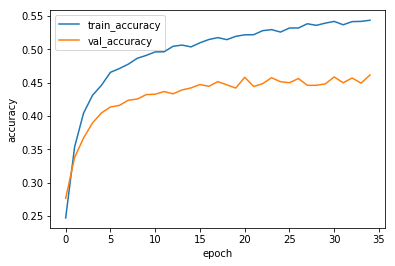

In [10]:
def show_history(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'val_accuracy'], loc='best')
    plt.show()

show_history(history)

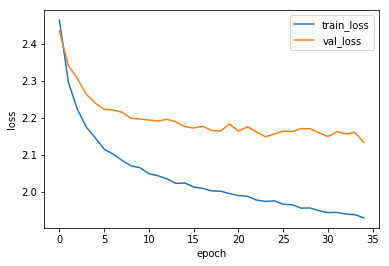

In [11]:
def show_history2(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'val_loss'], loc='best')
    plt.show()

show_history2(history)